### First implementaiton 

In [1]:
%load_ext autoreload
%autoreload 2

In [9]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import time
import os
import copy
import glob
import pandas as pd
import cv2
from skimage import io, transform
from utils import show_landmarks
from utils import prep_landmarks, show_landmarks, load_img
from PIL import Image

cudnn.benchmark = True
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Getting the data

In [4]:
!git clone https://github.com/udacity/P1_Facial_Keypoints.git
root_dir = 'P1_Facial_Keypoints/data/training/'
all_img_paths = glob.glob(os.path.join(root_dir, '*.jpg'))
data = pd.read_csv("P1_Facial_Keypoints/data/training_frames_keypoints.csv")

Cloning into 'P1_Facial_Keypoints'...
remote: Enumerating objects: 6043, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 6043 (delta 0), reused 1 (delta 0), pack-reused 6038
Receiving objects: 100% (6043/6043), 329.52 MiB | 43.93 MiB/s, done.
Resolving deltas: 100% (153/153), done.
Checking out files: 100% (5805/5805), done.


In [5]:
data.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,...,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,...,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,...,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
3,Angelo_Reyes_22.jpg,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,...,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
4,Kristen_Breitweiser_11.jpg,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,...,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0


## Dataset and Tranforms 

In [6]:
class FacesDataset(Dataset):
    """Face landmarks dataset"""
    
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        
        img_path = os.path.join(self.root_dir,
                               self.df.iloc[idx, 0])
        img = cv2.imread(img_path)/255.
        landmarks = self.df.iloc[idx, 1:]
        landmarks = np.array(landmarks).astype('float').reshape(-1, 2)
        sample = {'image': img, 'landmarks': landmarks}
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample['image'], sample['landmarks']

In [7]:
class Rescale(object):
    """Rescale the image in a sample to a given size with matching landmarks"""
    
    def __init__(self, output_size):
        assert isinstance(output_size, tuple)
        self.output_size = output_size
        
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        # scalling the image
        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        img = transform.resize(image, (new_h, new_w))
        
        # scalling the landmarks
        landmarks = landmarks * [new_w / w, new_h / h]
        # scaling the landmarks between 0, 1
        landmarks = landmarks / [new_w, new_h]
        
        return {'image': img, 'landmarks': landmarks}

# class RandomCrop(object):
#     """Crop randomly the image in sample"""
#     def __init__(self, output_size):
#         assert isinstance(output_size, (tuple, int))
#         if isinstance(output_size, int):
#             self.output_size = (output_size, output_size)
#         else:
#             assert len(output_size) == 2
#             self.output_size = output_size
        
#     def __call__(self, sample):
#         image, landmarks = sample['image'], sample['landmarks']
        
#         h, w = image.shape[:2]
#         new_h, new_w = self.output_size
        
#         top = np.random.randint(0, abs(h - new_h))
#         left = np.random.randint(0, abs(w - new_w))
        
        
#         image = image[top: top+new_h, left: left+new_w]
        
#         landmarks = landmarks - [left, top]
        
#         return {'image': image, 'landmarks': landmarks}
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors"""
    
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        image = image.transpose((2, 0, 1))
        
        kp_x = landmarks[:, 0].tolist()
        kp_y = landmarks[:, 1].tolist()
        kp2 = kp_x + kp_y
        
        return {'image': torch.from_numpy(image).float(),
               'landmarks': torch.tensor(kp2).float()}

    
class Normalize(object):
    """Normalize the image using Imagenet mean and std"""
    def __init__(self):
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
        
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        image = self.normalize(image)
        
        return {'image': image,
                'landmarks': landmarks}

In [8]:
from sklearn.model_selection import train_test_split

tfms = transforms.Compose([
    Rescale((224, 224)),
#     RandomCrop(224),
    ToTensor(),
    Normalize(),
])

train, valid = train_test_split(data, test_size=0.2, random_state=42)
train_dataset = FacesDataset(train.reset_index(drop=True), root_dir, tfms)
valid_dataset = FacesDataset(valid.reset_index(drop=True), root_dir, tfms)

train_loader = DataLoader(train_dataset, batch_size=32)
valid_loader = DataLoader(valid_dataset, batch_size=32)

dataloaders = {'train': train_loader, 'val': valid_loader}
datasets_sizes = {'train': len(train_dataset), 'val': len(valid_dataset)}
datasets_sizes

{'train': 2769, 'val': 693}

In [9]:
xb, yb = next(iter(train_loader))
xb.shape, yb.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32, 136]))

In [10]:
xb[0]

tensor([[[-0.9828, -1.0214, -1.1046,  ..., -1.7268, -1.7240, -1.7240],
         [-1.1968, -1.2279, -1.2940,  ..., -1.7268, -1.7240, -1.7240],
         [-1.3581, -1.3697, -1.3961,  ..., -1.7268, -1.7240, -1.7240],
         ...,
         [-1.2831, -1.2718, -1.2502,  ..., -0.6878, -0.6844, -0.6811],
         [-1.2731, -1.2617, -1.2411,  ..., -0.6752, -0.6752, -0.6752],
         [-1.2731, -1.2617, -1.2392,  ..., -0.6637, -0.6637, -0.6637]],

        [[-0.7834, -0.8229, -0.9027,  ..., -1.4083, -1.4055, -1.4055],
         [-0.9670, -0.9988, -1.0649,  ..., -1.4083, -1.4055, -1.4055],
         [-1.0777, -1.0897, -1.1166,  ..., -1.4083, -1.4055, -1.4055],
         ...,
         [-0.9722, -0.9606, -0.9385,  ..., -0.3636, -0.3602, -0.3568],
         [-0.9619, -0.9504, -0.9292,  ..., -0.3507, -0.3507, -0.3507],
         [-0.9619, -0.9504, -0.9273,  ..., -0.3390, -0.3390, -0.3390]],

        [[-0.5911, -0.6304, -0.7125,  ..., -1.0404, -1.0376, -1.0376],
         [-0.7622, -0.7939, -0.8604,  ..., -1

In [11]:
yb

tensor([[0.1879, 0.2013, 0.2282,  ..., 0.6096, 0.6096, 0.6096],
        [0.3544, 0.3418, 0.3418,  ..., 0.6229, 0.6229, 0.6229],
        [0.2543, 0.2717, 0.2832,  ..., 0.6244, 0.6244, 0.6244],
        ...,
        [0.3412, 0.3507, 0.3602,  ..., 0.6095, 0.6095, 0.6095],
        [0.1824, 0.1824, 0.1941,  ..., 0.6057, 0.6171, 0.6171],
        [0.2827, 0.2827, 0.2827,  ..., 0.6295, 0.6295, 0.6295]])

## Model

In [3]:
def get_model():
    model = models.vgg16(weights='VGG16_Weights.DEFAULT')
    for param in model.parameters():
        param.requires_grad = False

    model.avgpool = nn.Sequential(
      nn.Conv2d(512, 512, 3),
      nn.MaxPool2d(2),
      nn.Flatten()
    )

    model.classifier = nn.Sequential(
      nn.Linear(2048, 512),
      nn.ReLU(),
      nn.Dropout(0.5),
      nn.Linear(512, 136),
      nn.Sigmoid()
    )

    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1, verbose=True)
    return model.to(device), criterion, optimizer, exp_lr_scheduler

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    train_losess = []
    valid_losses = []
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs-1}')
        print('-'*10)
        
        # train and val phases
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0

            # iterate over data
            for idx, (inputs, points) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                points = points.to(device)

                # zero the parameters gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    _points = model(inputs)
                    loss = criterion(_points, points)

                    # backward + optimize if only in train
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # stats
                running_loss += loss.item()

            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / (idx+1)
            print(f'{phase} Loss: {epoch_loss:.4f}')
            
            if phase == 'train':
                train_losess.append(epoch_loss)
            else:
                valid_losses.append(epoch_loss)

            # keep the best model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')
    print(f'Best val Loss: {best_loss:.4f}')
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    # save model's best weight to desk
    torch.save(model.state_dict(), '03.pth')
    return model, train_losess, valid_losses

In [5]:
model, criterion, optimizer, exp_lr_scheduler = get_model()

Adjusting learning rate of group 0 to 1.0000e-04.


In [6]:
model, train_losses, valid_losess = train_model(model, criterion, optimizer, exp_lr_scheduler, 10)

Epoch 0/9
----------



KeyboardInterrupt



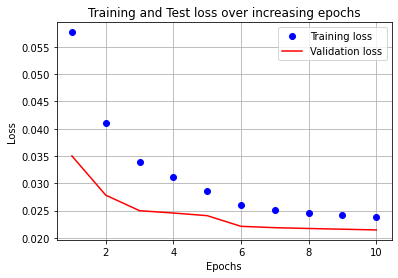

In [19]:
epochs = np.arange(10)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, valid_losess, 'r', label='Validation loss')
plt.title('Training and Test loss over increasing epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

In [23]:
def load_img(path, infer=False):
    """Load image and prepare it for inference"""
    normalization = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    
    
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.
    img = cv2.resize(img, (224, 224))

    if infer:
        img = torch.tensor(img).permute(2, 0, 1)
        img = normalization(img).float()
        return img.to(device)
    return img

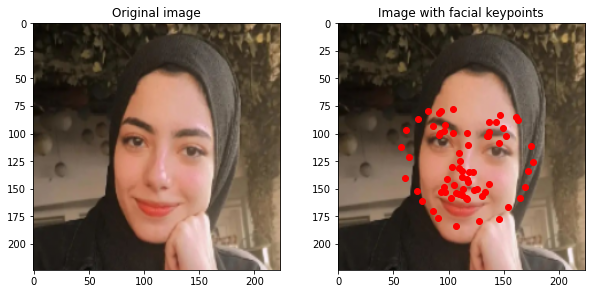

In [25]:
# ix = 3
img_path = '/content/Screenshot from 2022-08-25 23-23-10.png'
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.title('Original image')
# im = test_dataset.load_img(ix)
img = load_img(img_path)
plt.imshow(img)
plt.grid(False)
plt.subplot(222)
plt.title('Image with facial keypoints')
plt.imshow(img)
img = load_img(img_path, infer=True)
model.eval()
with torch.no_grad():
    kp = model(img[None]).flatten().detach().cpu()
plt.scatter(kp[:68]*224, kp[68:]*224, c='r')
plt.grid(False)
plt.show()

In [28]:
model, criterion, optimizer, exp_lr_scheduler = get_model()

Adjusting learning rate of group 0 to 1.0000e-04.


In [29]:
# loading model
model.load_state_dict(torch.load('/content/03.pth'))

<All keys matched successfully>

In [30]:
model, train_losses, valid_losess = train_model(model, criterion, optimizer, exp_lr_scheduler, 40)

Epoch 0/39
----------
Adjusting learning rate of group 0 to 1.0000e-04.
train Loss: 0.0245
val Loss: 0.0231

Epoch 1/39
----------
Adjusting learning rate of group 0 to 1.0000e-04.
train Loss: 0.0248
val Loss: 0.0231

Epoch 2/39
----------
Adjusting learning rate of group 0 to 1.0000e-04.
train Loss: 0.0238
val Loss: 0.0220

Epoch 3/39
----------
Adjusting learning rate of group 0 to 1.0000e-04.
train Loss: 0.0227
val Loss: 0.0229

Epoch 4/39
----------
Adjusting learning rate of group 0 to 1.0000e-05.
train Loss: 0.0219
val Loss: 0.0223

Epoch 5/39
----------
Adjusting learning rate of group 0 to 1.0000e-05.
train Loss: 0.0206
val Loss: 0.0203

Epoch 6/39
----------
Adjusting learning rate of group 0 to 1.0000e-05.
train Loss: 0.0197
val Loss: 0.0202

Epoch 7/39
----------
Adjusting learning rate of group 0 to 1.0000e-05.
train Loss: 0.0194
val Loss: 0.0199

Epoch 8/39
----------
Adjusting learning rate of group 0 to 1.0000e-05.
train Loss: 0.0190
val Loss: 0.0200

Epoch 9/39
--------

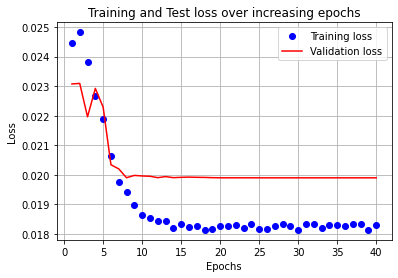

In [31]:
epochs = np.arange(40)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, valid_losess, 'r', label='Validation loss')
plt.title('Training and Test loss over increasing epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

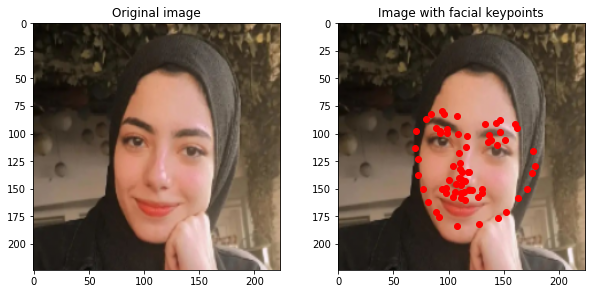

In [32]:
# ix = 3
img_path = '/content/Screenshot from 2022-08-25 23-23-10.png'
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.title('Original image')
# im = test_dataset.load_img(ix)
img = load_img(img_path)
plt.imshow(img)
plt.grid(False)
plt.subplot(222)
plt.title('Image with facial keypoints')
plt.imshow(img)
img = load_img(img_path, infer=True)
model.eval()
with torch.no_grad():
    kp = model(img[None]).flatten().detach().cpu()
plt.scatter(kp[:68]*224, kp[68:]*224, c='r')
plt.grid(False)
plt.show()

### Test the model locally 

In [7]:
# load best model
model.load_state_dict(torch.load('models/03.pth'))

<All keys matched successfully>

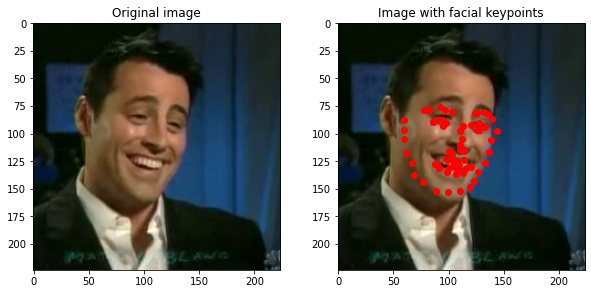

In [10]:
# ix = 3
img_path = 'data/test/Matt_LeBlanc_00.jpg'
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.title('Original image')
# im = test_dataset.load_img(ix)
img = load_img(img_path)
plt.imshow(img)
plt.grid(False)
plt.subplot(222)
plt.title('Image with facial keypoints')
plt.imshow(img)
img = load_img(img_path, infer=True)
model.eval()
with torch.no_grad():
    kp = model(img[None]).flatten().detach().cpu()
plt.scatter(kp[:68]*224, kp[68:]*224, c='r')
plt.grid(False)
plt.show()